In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
from numpy.fft import fftshift
from tqdm import tqdm

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat
from plancklens.wigners import wigners
from plancklens import n0s, nhl
from plancklens.n1 import n1
import matplotlib.patches as mpatches
import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline

In [2]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [40]:
# We define here the parameters for the profile of the cluster
M200, z = 4 * 1e14, 0.7
profname = 'nfw'
key = "cluster" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z}
hprofile = profile.profile(results, profname)
xmax = 3*hprofile.get_concentration(M200, z)
# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 6002

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 5000
ellmindat = 100

# Number of simulated maps 
nsims = 1

# Set CMB experiment for noise level and beam
cmb_exp='S4_sayan'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
libdir = op.join(libdir,"trunc")
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/Users/sayan/Project_Geneva/modules/lensit_sims/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky6002/M200_4.000000E+14_z0.7/1_sims/trunc


In [41]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:321: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:322: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [42]:
ell = np.arange(ellmaxsky+1)
lib_skyalm = clustermaps.lib_skyalm
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
kappa_map = clustermaps.len_cmbs.kappa_map
from scipy.interpolate import UnivariateSpline
kappa_ell_bin = lib_skyalm.bin_realpart_inell(lib_skyalm.map2alm(kappa_map))[ell]
kappa_ell_lensit = UnivariateSpline(ell, kappa_ell_bin, s=0)
#kappa_l = kappa_ell_lensit(ell)
kappa_l_1 = kappa_ell_lensit(ell)

In [26]:
kappa_l.shape

(1373,)

In [19]:
ft_anal = hprofile.analitic_kappa_ft(M200, z, xmax, ell)

In [24]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])
el = ell[1:]

Text(0.5, 0, '$\\ell$')

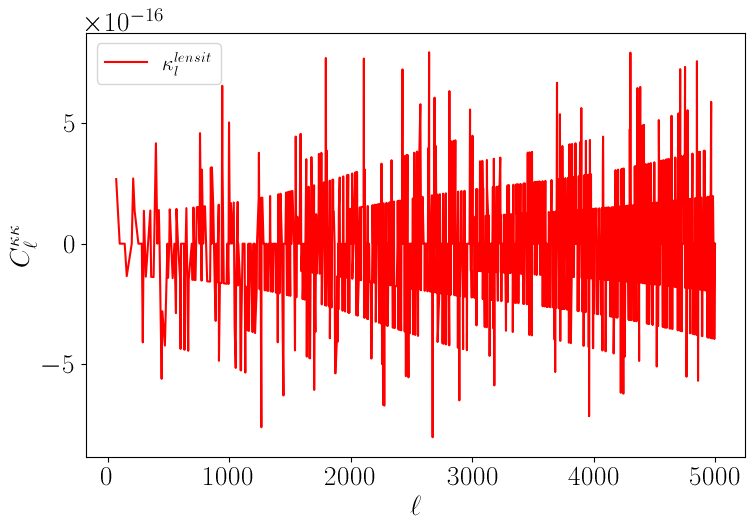

In [29]:
plt.plot(el, (kappa_l[1:]-kappa_l_1[el])/(kappa_l_1[el]), c="r", label=r'$\kappa_l^{lensit}$')
#plt.plot(el, kappa_l_1[el]*lbox_rad, c="r", label=r'$\kappa_l^{lensit}$')
#plt.plot(el, cpp_fid[el]*pp_to_kk(el), label="LSS")
#plt.plot(el, ft_anal[1:], label="cluster")
#plt.plot(el, ft_anal[el], label="cluster")
plt.legend()
plt.ylabel(r"$C^{\kappa\kappa}_{\ell}$")
plt.xlabel(r"$\ell$")
#plt.semilogy()

In [118]:
kappa_l_mean_lss = np.loadtxt("./files_max5k_out6k/kappa_l_MAP_lss_nit30.dat")
#kappa_l_mean_lss_20 = np.loadtxt("./files_max5k_out6k/kappa_l_MAP_lss.dat")

In [13]:
kappa_l_mean = np.loadtxt("./files_max5k_out6k/kappa_l_MAP_QEwc_QEc_lmaxsky5k.dat")[0]
kappa_l_mean_1 = np.loadtxt("./files_max5k_out6k/kappa_l_MAP_QEwc_QEc_lmaxsky5k.dat")[1]
kappa_l_mean_2 = np.loadtxt("./files_max5k_out6k/kappa_l_MAP_QEwc_QEc_lmaxsky5k.dat")[2]

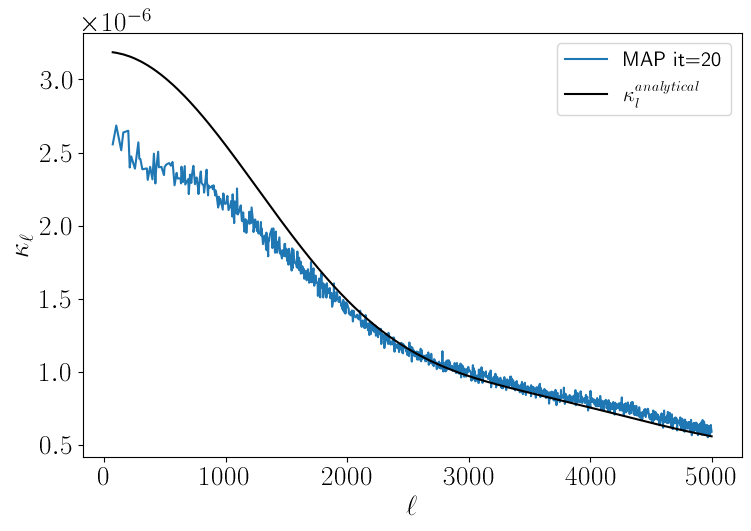

In [135]:
#ell, = np.where(lib_skyalm.get_Nell()[:6200+1])
#el = ell[1:]
plt.plot(el, kappa_l_mean_lss_20[el] , label="MAP it=20")
#plt.plot(el, kappa_l_mean_lss[el] , alpha=0.8, label="MAP it=30")

#plt.plot(el, kappa_l_mean[el], label="MAP")
#plt.plot(el, kappa_l_mean_2[el]*fact[el], label="QE with cut")
#plt.plot(el, kappa_l_mean_2[el], label="QE with cut - wrong response")
#plt.plot(el, kappa_l_mean_1[el], label="QE without cut")
#plt.plot(el, kappa_l[el], c="r", label=r'$\kappa_l^{analytical}$')
plt.plot(el, ft_anal[el]/(lbox_rad), c="k", label=r'$\kappa_l^{analytical}$')

#plt.semilogy()
plt.xlabel("$\ell$")
plt.ylabel("$\kappa_\ell$")
plt.legend()
#plt.savefig("../plots/kappa_l.pdf")

In [105]:
from scipy.special import jv
def kappa_th_bessel(theta_amin, kappa_l, elmax):
    el_r, = np.where(lib_skyalm.get_Nell()[:elmax+1])
    el_range = el_r[1:]
    theta_rad = theta_amin * np.pi / 60 / 180
    kappa_el = kappa_l[el_range]
    bessel = jv(1, el_range*theta_rad)
    integrand = el_range*kappa_el*bessel
    kappa_el1 = np.trapz(integrand, el_range)/ 2 / np.pi 
    return kappa_el1

from scipy.special import jv
def kappa_th_bessel_1(theta_amin, kappa_l, elmax):
    el_r, = np.where(lib_skyalm.get_Nell()[:elmax+1])
    el_range = el_r[1:]
    theta_rad = theta_amin * np.pi / 60 / 180
    kappa_el = kappa_l[el_range]
    bessel = jv(0, el_range*theta_rad)
    integrand = el_range*kappa_el*bessel
    kappa_el1 = np.trapz(integrand, el_range)/ 2 / np.pi 
    return kappa_el1

In [19]:
# function to go from kappa_l to alpha_l
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def p_to_k(ls):
    return ls * (ls+1.) * 0.5

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def k_to_p(ls):
    return cli(p_to_k(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd

def alpha_to_k(ls):
    return ls * 0.5

def k_to_alpha(ls):
    return cli(alpha_to_k(ls))

In [20]:
theta = np.linspace(0.0, 100, 1000)

In [101]:
ell = np.arange(ellmaxsky+1)
#alpha_l = kappa_l/(ell_r) * 2
alpha_l_anal = ft_anal*k_to_alpha(ell)


In [22]:
kappa_l_mean[ell].shape

(5001,)

In [23]:
fact = np.loadtxt("ratio_old_v_new.txt")

In [102]:
lmax_int = ellmaxsky
theta = np.linspace(0.0, 100, 1000)
kappa_thet_bessel = np.zeros((len(theta)))
kappa_thet_bessel_lss = np.zeros((len(theta)))
kappa_thet_bessel_uc = np.zeros((len(theta)))
kappa_thet_bessel_c = np.zeros((len(theta)))
kappa_thet_bessel_ = np.zeros((len(theta)))
kappa_thet_bessel_wc = np.zeros((len(theta)))
for th in tqdm(range(len(theta))):
    #kappa_thet_bessel[th] = kappa_th_bessel(theta[th], alpha_l, elmax=lmax_int)
    kappa_thet_bessel_uc[th] = kappa_th_bessel(theta[th], ft_anal*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_[th] = kappa_th_bessel(theta[th], kappa_l_mean[ell]*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_lss[th] = kappa_th_bessel(theta[th], kappa_l_mean_lss[ell]*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_c[th] = kappa_th_bessel(theta[th], kappa_l_mean_2[ell]*fact*k_to_alpha(ell), elmax=lmax_int)
    kappa_thet_bessel_wc[th] = kappa_th_bessel(theta[th], kappa_l_mean_1[ell]*k_to_alpha(ell), elmax=lmax_int)

100%|██████████| 1000/1000 [00:13<00:00, 75.71it/s]


In [110]:
lmax_int = ellmaxsky
theta = np.linspace(0.0, 10, 1000)
kappa_thet_bessel = np.zeros((len(theta)))
kappa_thet_bessel_uc = np.zeros((len(theta)))
kappa_thet_bessel_c = np.zeros((len(theta)))
kappa_thet_bessel_ = np.zeros((len(theta)))
kappa_thet_bessel_wc = np.zeros((len(theta)))
for th in tqdm(range(len(theta))):
    #kappa_thet_bessel[th] = kappa_th_bessel(theta[th], alpha_l, elmax=lmax_int)
    kappa_thet_bessel_uc[th] = kappa_th_bessel_1(theta[th], ft_anal, elmax=lmax_int)
    kappa_thet_bessel_lss[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_lss[ell], elmax=lmax_int)
    kappa_thet_bessel_[th] = kappa_th_bessel_1(theta[th], kappa_l_mean[ell], elmax=lmax_int)
    kappa_thet_bessel_c[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_2[ell]*fact, elmax=lmax_int)
    kappa_thet_bessel_wc[th] = kappa_th_bessel_1(theta[th], kappa_l_mean_1[ell], elmax=lmax_int)

100%|██████████| 1000/1000 [00:12<00:00, 78.91it/s]


In [31]:
theta = np.loadtxt("./files_max5k_out6k/kappa_th_map_sm.dat")[0]
kappa_prof_th_mean = np.loadtxt("./files_max5k_out6k/kappa_th_map_sm.dat")[1]
kappa_prof_th_error = np.loadtxt("./files_max5k_out6k/kappa_th_map.dat")[2]
kappa_prof_th_mean_1 = np.loadtxt("./files_max5k_out6k/kappa_th_qe_wc.dat")[1]
kappa_prof_th_error_1 = np.loadtxt("./files_max5k_out6k/kappa_th_qe_wc.dat")[2]
kappa_prof_th_mean_2 = np.loadtxt("./files_max5k_out6k/kappa_th_qe_c.dat")[1]
kappa_prof_th_error_2 = np.loadtxt("./files_max5k_out6k/kappa_th_qe_c.dat")[2]

In [33]:
nm = np.loadtxt("./files_max5k_out6k/normalisation_cstMF_lmax5k_lmin100_lmaxout6k_nit20_sims1k.dat")

In [31]:
import numpy as np
from scipy.interpolate import UnivariateSpline

def smooth_array(x, arr, smoothing_factor):
    spline = UnivariateSpline(x, arr)
    spline.set_smoothing_factor(smoothing_factor)
    smoothed_arr = spline(x)
    return smoothed_arr

In [60]:
ellmaxsky = 6000
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])
el = ell[1:]

In [61]:
ell

array([   0,   70,   99, ..., 5995, 5996, 5999])

In [62]:
nm_smooth = smooth_array(el, nm[el], 0.05)

In [53]:
nm_smooth

array([0.87465613, 0.84730148, 0.81002402, ..., 0.01541888, 0.01516341,
       0.01490954])

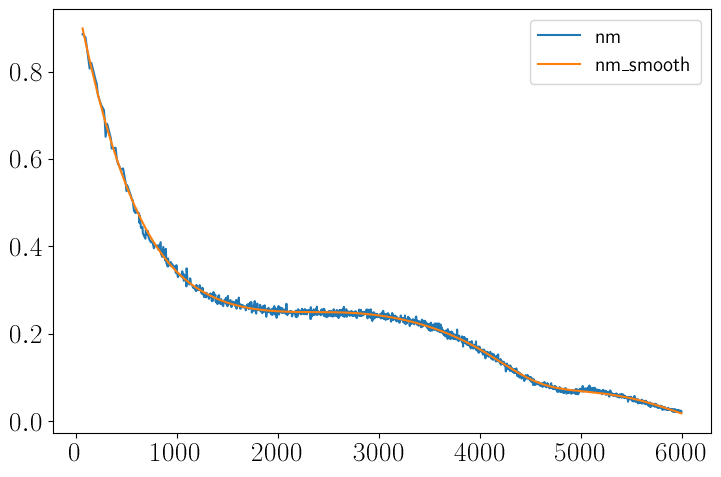

In [63]:
#plot nm and nm_smooth
plt.plot(el, nm[el], label="nm")
plt.plot(el, nm_smooth, label="nm_smooth") 
plt.legend()   

In [85]:
nm_1 = np.loadtxt("./files_max5k_out6k/normalisation_cstMF_lmax5k_lmin100_lmaxout5k_nit30_sims1k.dat")
nm_2 = np.loadtxt("./files_max5k_out6k/normalisation_cstMF_lmax5k_lmin100_lmaxout5k_nit40_sims1k.dat")

In [33]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

In [34]:
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)

In [35]:
li.get_config(clustermaps.cmb_exp)

(1.0, 1.4142135623730951, 1.0, 100, 4000)

In [132]:
N0s_it, _ = n0s.get_N0_iter('ptt', sN_uKamin, sN_uKaminP, Beam_FWHM_amin, cls_unl_fid,  lmin_cmb=100, lmax_cmb=5000, itermax=20, lmax_qlm=5000)


 [00:00:17]  ---------> 95%


In [133]:
wf_qe = cpp_fid/(cpp_fid+N0s_it[19])

/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_35339/751962960.py:1: RuntimeWarning: invalid value encountered in true_divide
  wf_qe = cpp_fid/(cpp_fid+N0s_it[19])


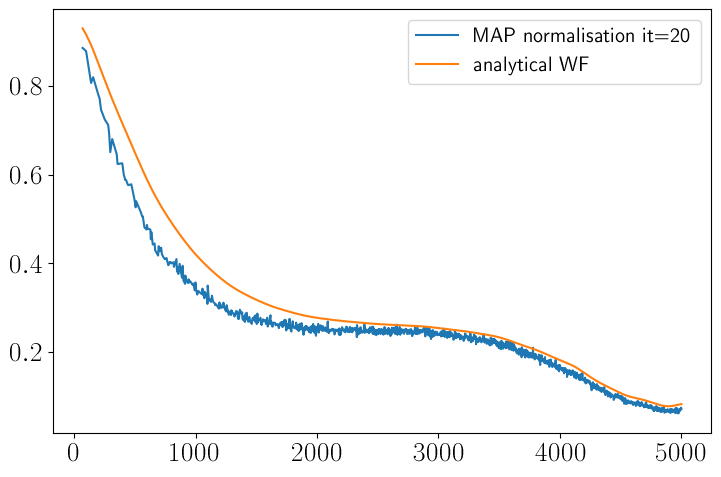

In [134]:
plt.plot(el, nm[el], label="MAP normalisation it=20")
#plt.plot(el, nm_1[el], label="MAP normalisation it=30")
#plt.plot(el, (nm_1[el] - nm[el])/nm[el], label="fractional difference between it=20 and 30")

#plt.plot(el, nm_2[el], label="MAP normalisation it=40")
plt.plot(el, wf_qe[el], label=" analytical WF")
plt.legend()
#plt.semilogy()

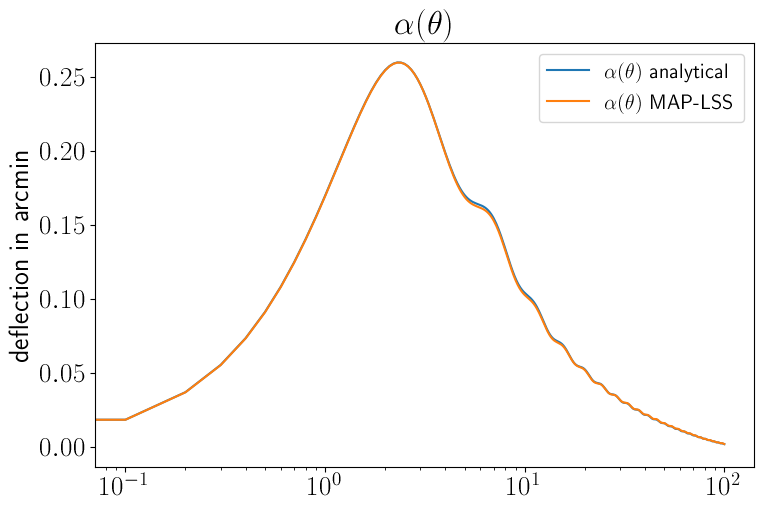

In [104]:
#plt.plot(theta, kappa_thet_bessel*lbox_rad, label=r" capped $\kappa(\theta)$")
#plt.plot(theta, kappa_thet_bessel_uc * 60 *180 / np.pi , label=r" $\alpha(\theta)$ lmax=200k")
plt.plot(theta, kappa_thet_bessel_uc * 60 *180 / np.pi , label=r" $\alpha(\theta)$ analytical")
#plt.plot(theta, kappa_thet_bessel_ * lbox_rad* 60 *180 / np.pi , label=r" $\alpha(\theta)$ MAP")
plt.plot(theta, kappa_thet_bessel_lss * lbox_rad* 60 *180 / np.pi , label=r" $\alpha(\theta)$ MAP-LSS")
#plt.plot(theta, kappa_thet_bessel_c * lbox_rad * 60 *180 / np.pi , label=r" $\alpha(\theta)$ QE with cut")
#plt.plot(theta, kappa_thet_bessel_wc * lbox_rad * 60 *180 / np.pi , label=r" $\alpha(\theta)$ QE without cut")
# Add a horizontal line at zero
#plt.axhline(y=0, c="r")
plt.semilogx()
plt.ylabel("deflection in arcmin")
plt.title(r"$\alpha(\theta)$")
plt.legend()

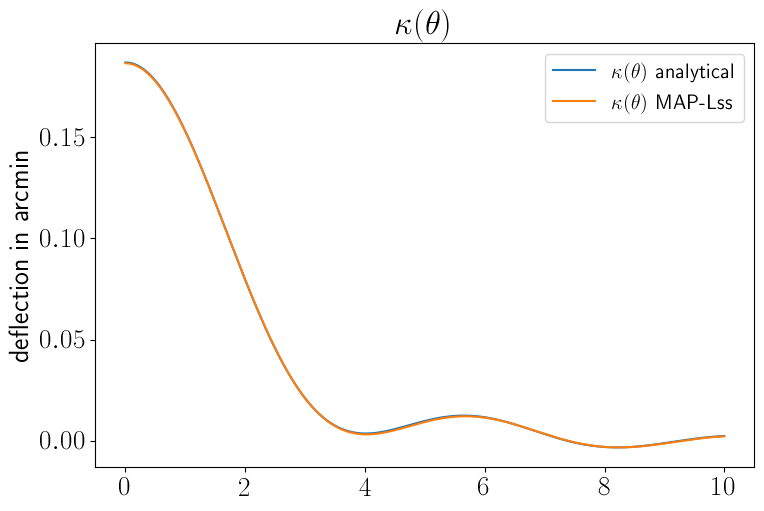

In [113]:
#plt.plot(theta, kappa_thet_bessel*lbox_rad, label=r" capped $\kappa(\theta)$")
#plt.plot(theta, kappa_thet_bessel_uc  , label=r" $\kappa(\theta)$ lmax=200k")
plt.plot(theta, kappa_thet_bessel_uc  , label=r" $\kappa(\theta)$ analytical")
plt.plot(theta, kappa_thet_bessel_lss * lbox_rad , label=r" $\kappa(\theta)$ MAP-Lss")
#plt.plot(theta, kappa_thet_bessel_ * lbox_rad , label=r" $\kappa(\theta)$ MAP")
#plt.plot(theta, kappa_thet_bessel_c * lbox_rad  , label=r" $\kappa(\theta)$ QE with cut")
#plt.plot(theta, kappa_thet_bessel_wc * lbox_rad  , label=r" $\kappa(\theta)$ QE without cut")
# Add a horizontal line at zero
#plt.axhline(y=0, c="r")
#plt.semilogx()
plt.ylabel("deflection in arcmin")
plt.title(r"$\kappa(\theta)$")
plt.legend()

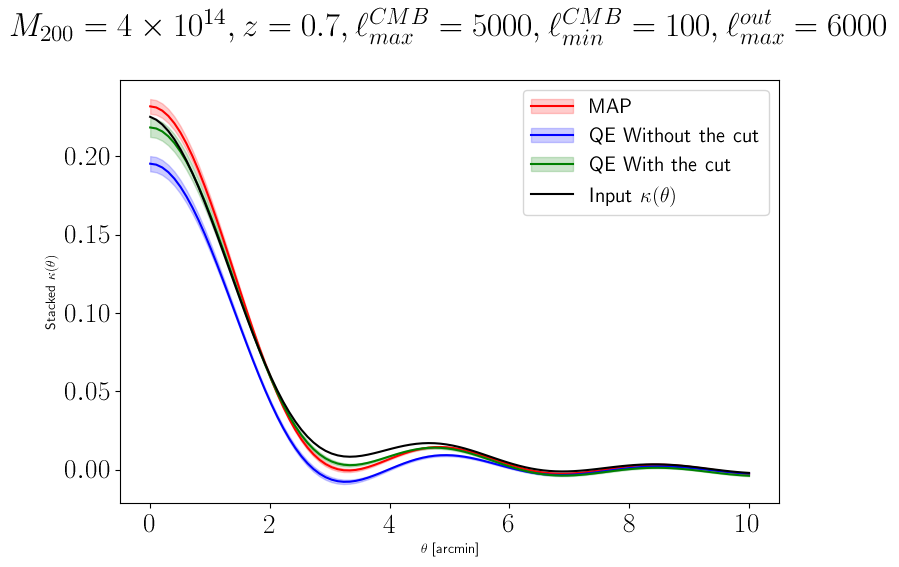

In [32]:
styles = {
    'MAP': {
        'color': 'red',
        'label': 'Without the cut',
        'fill_color': 'red'
    },
    'QE_without_cut': {
        'color': 'blue',
        'label': 'With the cut',
        'fill_color': 'blue'
    },
    'QE_with_cut': {
        'color': 'green',
        'label': 'With the cut',
        'fill_color': 'green'
    },    
    'input_kappa': {
        'color': 'black',
        'label': r'Input $\kappa (\theta)$'
    }
}

fig, ax = plt.subplots()

# Plot with MAP
line1, = ax.plot(theta, kappa_prof_th_mean, color=styles['MAP']['color'])
error1 = ax.fill_between(theta, kappa_prof_th_mean - kappa_prof_th_error, kappa_prof_th_mean + kappa_prof_th_error,
                         alpha=0.2, color=styles['MAP']['fill_color'])

 #Plot with QE with cut
line2, = ax.plot(theta, kappa_prof_th_mean_1, color=styles['QE_without_cut']['color'])
error2 = ax.fill_between(theta, kappa_prof_th_mean_1 - kappa_prof_th_error_1, kappa_prof_th_mean_1 + kappa_prof_th_error_1,
                         alpha=0.2, color=styles['QE_without_cut']['fill_color'])

# Plot with QE without cut
line3, = ax.plot(theta, kappa_prof_th_mean_2, color=styles['QE_with_cut']['color'])
error3 = ax.fill_between(theta, kappa_prof_th_mean_2 - kappa_prof_th_error_2, kappa_prof_th_mean_2 + kappa_prof_th_error_2,
                         alpha=0.2, color=styles['QE_with_cut']['fill_color'])

# Plot input kappa
line4, = ax.plot(theta, kappa_thet_bessel_uc, color=styles['input_kappa']['color'])

# Set labels and title
ax.set_xlabel(r'$\theta$ [arcmin]')
ax.set_ylabel(r'Stacked $\kappa(\theta)$')
ax.set_title(r'$M_{200} = 4 \times 10^{14}, z=0.7, \ell_{max}^{CMB}=5000, \ell_{min}^{CMB}=100, \ell_{max}^{out}=6000$',
             y=1.08)

# Create custom legend handles for shaded regions with lines
error_patch1 = mpatches.Patch(color=styles['MAP']['fill_color'], alpha=error1.get_alpha(), label='Error')
error_patch2 = mpatches.Patch(color=styles['QE_without_cut']['fill_color'], alpha=error2.get_alpha(), label='Error')
error_patch3 = mpatches.Patch(color=styles['QE_with_cut']['fill_color'], alpha=error3.get_alpha(), label='Error')

# Show the legend with custom handles
ax.legend([(line1, error_patch1), (line2, error_patch2), (line3, error_patch3), line4], ['MAP','QE Without the cut','QE With the cut', r'Input $\kappa (\theta)$'])

# Show the plot
#plt.show()

In [130]:
data_1 = clustermaps.len_cmbs.defl_map
data_2 = clustermaps.len_cmbs._get_f(0).get_kappa()
data_1 = np.sqrt(data_1[0]**2 + data_1[1]**2)

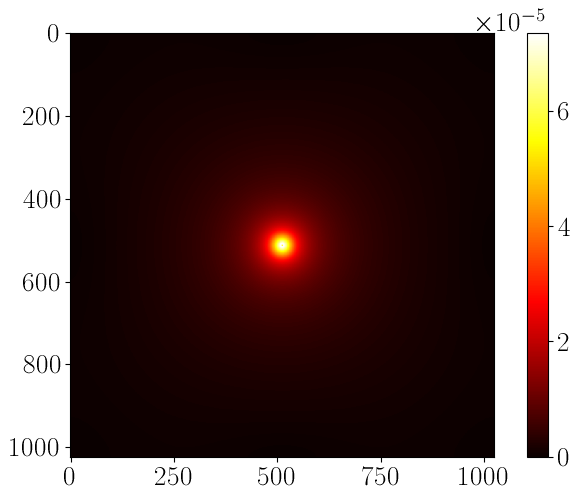

In [83]:
plt.imshow(np.fft.fftshift(data_1), cmap='hot', interpolation='nearest')
plt.colorbar()

In [120]:
shape = np.array([npix,npix])
X, Y =  np.meshgrid(np.concatenate((np.arange(0,shape[0]//2), np.arange(-shape[0]//2,0))), np.concatenate((np.arange(0,shape[1]//2), np.arange(-shape[1]//2,0))))
data = kappa_map
radius = 10

In [121]:
# Calculate the distance from the center
center = (0, 0)  # Center coordinates of the dataset
distances = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

# Compute the average value for each distance
unique_distances = np.unique(distances)  # Unique distance values
unique_distances_1 = []
for distance in unique_distances:
    if distance*0.3 < radius:
        #print(distance)
        unique_distances_1 = np.append(unique_distances_1, distance)

In [111]:
mean_values_1 = []
for distance in tqdm(unique_distances_1):
    values = data_1[distances == distance]  # Values at the given distance
    mean_value = np.mean(values)  # Compute the mean value
    mean_values_1.append(mean_value)

100%|██████████| 26551/26551 [00:23<00:00, 1116.33it/s]


In [122]:
mean_values_2 = []
for distance in tqdm(unique_distances_1):
    values = data_2[distances == distance]  # Values at the given distance
    mean_value = np.mean(values)  # Compute the mean value
    mean_values_2.append(mean_value)

100%|██████████| 365/365 [00:00<00:00, 1042.68it/s]


[]

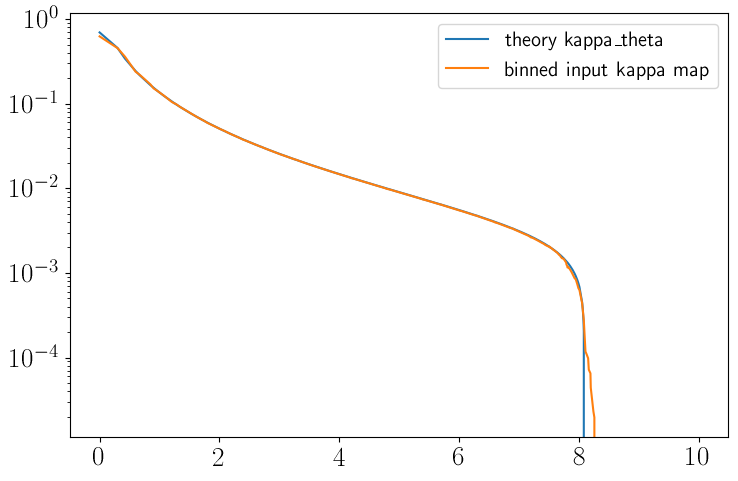

In [123]:
plt.plot(unique_distances_1*0.3, hprofile.kappa_theta(M200, z, unique_distances_1*0.3, xmax), label="theory kappa_theta")
plt.plot(unique_distances_1*0.3, mean_values_2, label="binned input kappa map")
plt.legend()
plt.semilogy()

ValueError: x and y must have same first dimension, but have shapes (365,) and (26551,)

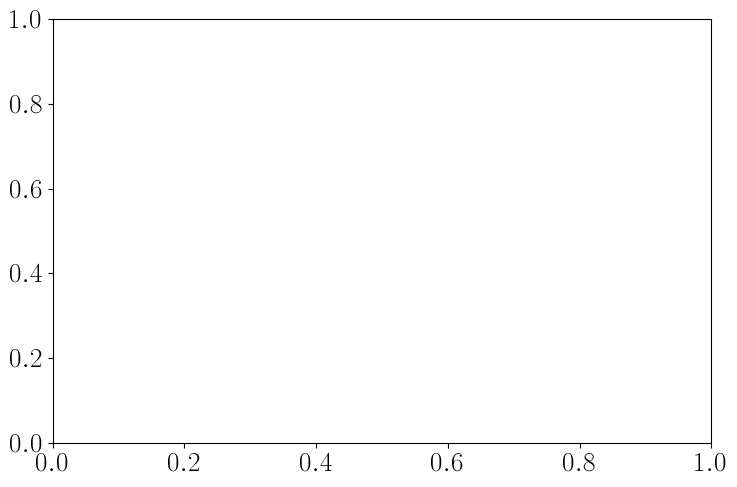

In [125]:
#plt.plot(unique_distances_1*0.3, hprofile.kappa_theta(M200, z, unique_distances_1*0.3, xmax), label="deflection")
plt.plot(unique_distances_1*0.3, np.array(mean_values_1)* 60 *180 / np.pi , label="deflection")
plt.plot(unique_distances_1*0.3, data_1[0,unique_distances_1]* 60 *180 / np.pi , label="deflection")
plt.semilogx()

In [118]:
np.array(mean_values_1)* 60 *180 / np.pi

array([4.20043911e-18, 1.68838705e-01, 2.02322426e-01, ...,
       7.16725631e-03, 7.06205783e-03, 6.78029778e-03])

[]

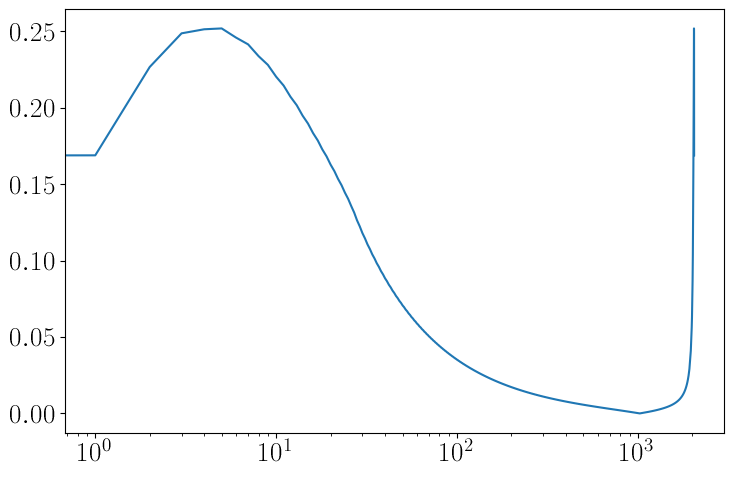

In [131]:
plt.plot(data_1[0]* 60 *180 / np.pi)
plt.semilogx()